In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
%%capture
!pip install torchvision

#### Prepare for Dataset

In [3]:
transform = transforms.Compose(
    [transforms.Resize((227, 227)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [9]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

net = Net()     
net.to(device) 

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(net.parameters(), lr=0.001, momentum=0.9) 

In [8]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[epoch: 0, i:    99] avg mini-batch loss: 2.316
[epoch: 0, i:   199] avg mini-batch loss: 2.307
[epoch: 0, i:   299] avg mini-batch loss: 2.304
[epoch: 0, i:   399] avg mini-batch loss: 2.303
[epoch: 0, i:   499] avg mini-batch loss: 2.307
[epoch: 0, i:   599] avg mini-batch loss: 2.300
[epoch: 0, i:   699] avg mini-batch loss: 2.307
[epoch: 0, i:   799] avg mini-batch loss: 2.307
[epoch: 0, i:   899] avg mini-batch loss: 2.302
[epoch: 0, i:   999] avg mini-batch loss: 2.303
[epoch: 0, i:  1099] avg mini-batch loss: 2.304
[epoch: 0, i:  1199] avg mini-batch loss: 2.304
[epoch: 0, i:  1299] avg mini-batch loss: 2.305
[epoch: 0, i:  1399] avg mini-batch loss: 2.303
[epoch: 0, i:  1499] avg mini-batch loss: 2.303
[epoch: 0, i:  1599] avg mini-batch loss: 2.303
[epoch: 0, i:  1699] avg mini-batch loss: 2.302
[epoch: 0, i:  1799] avg mini-batch loss: 2.304
[epoch: 0, i:  1899] avg mini-batch loss: 2.305
[epoch: 0, i:  1999] avg mini-batch loss: 2.302
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 1, i:  4699] avg mini-batch loss: 2.304
[epoch: 1, i:  4799] avg mini-batch loss: 2.303
[epoch: 1, i:  4899] avg mini-batch loss: 2.303
[epoch: 1, i:  4999] avg mini-batch loss: 2.302
[epoch: 1, i:  5099] avg mini-batch loss: 2.303
[epoch: 1, i:  5199] avg mini-batch loss: 2.303
[epoch: 1, i:  5299] avg mini-batch loss: 2.306
[epoch: 1, i:  5399] avg mini-batch loss: 2.302
[epoch: 1, i:  5499] avg mini-batch loss: 2.303
[epoch: 1, i:  5599] avg mini-batch loss: 2.305
[epoch: 1, i:  5699] avg mini-batch loss: 2.302
[epoch: 1, i:  5799] avg mini-batch loss: 2.303
[epoch: 1, i:  5899] avg mini-batch loss: 2.302
[epoch: 1, i:  5999] avg mini-batch loss: 2.304
[epoch: 1, i:  6099] avg mini-batch loss: 2.303
[epoch: 1, i:  6199] avg mini-batch loss: 2.304
[epoch: 1, i:  6299] avg mini-batch loss: 2.302
[epoch: 1, i:  6399] avg mini-batch loss: 2.303
[epoch: 1, i:  6499] avg mini-batch loss: 2.304
[epoch: 1, i:  6599] avg mini-batch loss: 2.304
[epoch: 1, i:  6699] avg mini-batch loss

[epoch: 2, i:  9299] avg mini-batch loss: 2.304
[epoch: 2, i:  9399] avg mini-batch loss: 2.301
[epoch: 2, i:  9499] avg mini-batch loss: 2.304
[epoch: 2, i:  9599] avg mini-batch loss: 2.303
[epoch: 2, i:  9699] avg mini-batch loss: 2.303
[epoch: 2, i:  9799] avg mini-batch loss: 2.303
[epoch: 2, i:  9899] avg mini-batch loss: 2.302
[epoch: 2, i:  9999] avg mini-batch loss: 2.303
[epoch: 2, i: 10099] avg mini-batch loss: 2.302
[epoch: 2, i: 10199] avg mini-batch loss: 2.305
[epoch: 2, i: 10299] avg mini-batch loss: 2.304
[epoch: 2, i: 10399] avg mini-batch loss: 2.303
[epoch: 2, i: 10499] avg mini-batch loss: 2.303


KeyboardInterrupt: 

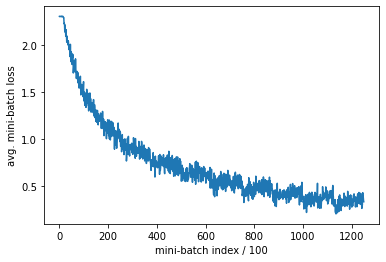

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

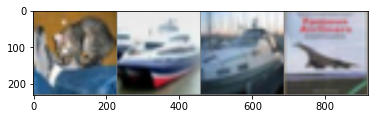

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [11]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [12]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %


In [13]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 87 %
Accuracy of  bird : 69 %
Accuracy of   cat : 60 %
Accuracy of  deer : 76 %
Accuracy of   dog : 72 %
Accuracy of  frog : 89 %
Accuracy of horse : 76 %
Accuracy of  ship : 90 %
Accuracy of truck : 88 %


In [20]:
import torch.nn.functional as F
from torchvision import transforms

# Define a function to enhance the misclassified images
def enhance_image(image):
    # Enhance the image
    enhanced_image = transforms.functional.adjust_brightness(image, brightness_factor=1.2)
    enhanced_image = transforms.functional.adjust_contrast(enhanced_image, contrast_factor=1.5)
    enhanced_image = transforms.functional.adjust_sharpness(enhanced_image, sharpness_factor=1.5)
    return enhanced_image

misclassified_images = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                # Enhance the misclassified image
                enhanced_image = enhance_image(images[i])
                # Save the enhanced image and its label
                misclassified_images.append((enhanced_image, labels[i]))

# Predict again using the enhanced misclassified images
correct = 0
total = 0
with torch.no_grad():
    for data in misclassified_images:
        image, label = data
        image = image.to(device)
        output = net(image.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        total += 1
        if predicted == label:
            correct += 1

print('Accuracy of the network on the enhanced misclassified images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the enhanced misclassified images: 25 %


In [21]:
torch.save(net.state_dict(), 'AlexNet.pt')

In [10]:
import torchsummary

In [11]:
torchsummary.summary(net, input_size=(3, 227, 227))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    